# EN3160 Assignment 2 on Fitting and Alignment

>Index No : 200462U

>Name : Randika Perera

## Question 1


Largest Circle Parameters:
Radius: 72.40773439350254
Center Coordinates (x, y): (98, 884)

Range of σ values used:
Minimum σ: 0.4
Maximum σ: 51.200000000000045



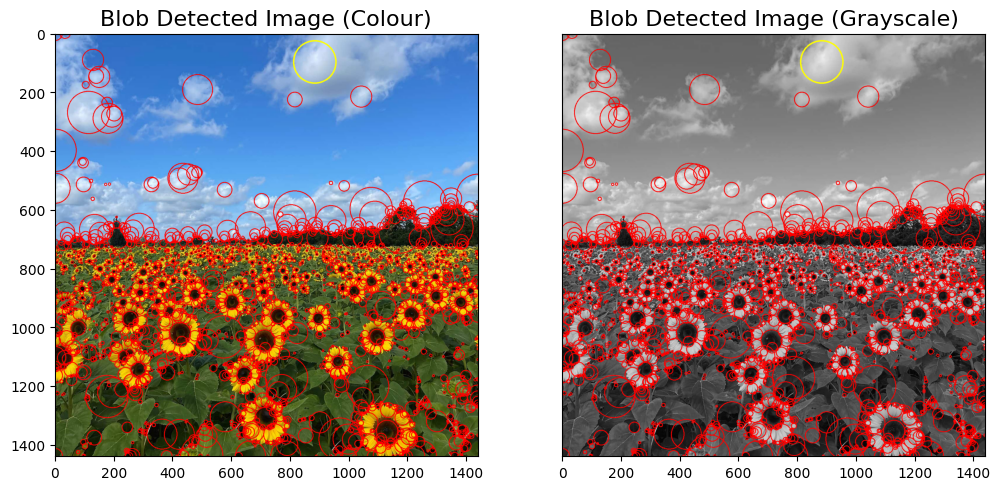

In [53]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt



# Function Definitions

def log_kernel(sigma, size):

        if size % 2 == 0:  # Size must be odd
                size = size + 1

        sigma2 = sigma ** 2  # Sigma squared
        idx_range = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)  # Index range 
        x_idx, y_idx = np.meshgrid(idx_range, idx_range)  # Meshgrid of index range
        tmp_cal = -(np.square(x_idx) + np.square(y_idx)) / (2. * sigma2)  # Calculate the exponential term
        kernel = np.exp(tmp_cal)  # Computes the Gaussian kernel
        kernel[kernel < np.finfo(float).eps * np.amax(kernel)] = 0  # Discards very small numbers
        k_sum = np.sum(kernel)  # Sums all the elements in the kernel

        if k_sum != 0:
                kernel /= np.sum(kernel)  # Normalizes the kernel

        tmp_kernel = np.multiply(kernel, np.square(x_idx) + np.square(y_idx) - 2 * sigma2) / (sigma2 ** 2)  # Computes the Laplacian component of the LoG filter
        kernel = tmp_kernel - np.sum(tmp_kernel) / (size ** 2) # Final LoG filter
        return kernel




def show_kernel(kernel):
        plt.imshow(kernel, cmap='viridis')
        plt.colorbar()
        plt.title('Kernel')
        plt.show()






# Main code starts here

img_name = "the_berry_farms_sunflower_field"
img = cv.imread("../Data/" + img_name + ".jpeg")


gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) # Convert to grayscale
gray = np.float32(gray) # Convert to float32
cv.normalize(gray, gray, 1, 0, cv.NORM_MINMAX) # Normalize the image


sigma0 = 0.4 # Initial sigma. Selected through trial and error to produce the best results
k = np.sqrt(2) # Scale factor
num_scales = 15 # Number of scales
sigmas = sigma0 * np.power(k, np.arange(num_scales)) # Array of sigma values for each scale


# LoG Filtering at Multiple Scales
img_stack = None

for i in range(num_scales):

        size = int(2 * np.ceil(4 * sigmas[i]) + 1) # Size of the kernel

        kernel = log_kernel(sigmas[i], size) * np.power(sigmas[i], 2) # LoG filter
        #show_kernel(kernel) # Display the kernel

        filtered = cv.filter2D(gray, cv.CV_32F, kernel) # Filter the image with the LoG filter
        filtered = pow(filtered, 2) # Square the filtered image
        
        # Filtered images are stored in img_stack
        if i == 0:  #
                img_stack = filtered 
        else:
                img_stack = np.dstack((img_stack, filtered)) 

# Maximum Response Extraction
scale_space = None 

for i in range(num_scales):
        filtered = cv.dilate(img_stack[:, :, i], np.ones((3, 3)), cv.CV_32F, (-1, -1), 1, cv.BORDER_CONSTANT) # Dilate the image
        
        # Filtered images are stored in scale_space
        if i == 0:
                scale_space = filtered
        else:
                scale_space = np.dstack((scale_space, filtered))

max_stack = np.amax(scale_space, axis=2)  # Find the maximum response across all the dilated images along the third axis (axis=2)
max_stack = np.repeat(max_stack[:, :, np.newaxis], num_scales, axis=2)  # Expand the 2D image into a 3D stack of identical 2D images, effectively replicating the maximum response image for each scale
max_stack = np.multiply((max_stack == scale_space), scale_space)  # Multiplies the 3D stack of images by a binary mask. The mask (max_stack == scale_space) will be 1 where the maximum response matches the original scale space and 0 elsewhere. This effectively retains only the maximum responses in the stack.


radius_vec = None
x_vec = None
y_vec = None


for i in range(num_scales):
        
        radius = np.sqrt(2) * sigmas[i] # Radius of the blob
        threshold = 0.01 # Threshold for the maximum response
        # filter out redundant response
        valid = (max_stack[:, :, i] == img_stack[:, :, i]) * img_stack[:, :, i] # Retains only the maximum responses in the stack
        valid[valid <= threshold] = 0 # Discards responses below the threshold
        (x, y) = np.nonzero(valid) # Finds the coordinates of the maximum responses
        
        if i == 1:
                x_vec = x # Creates a vector of the x coordinates of the maximum responses
                y_vec = y # Creates a vector of the y coordinates of the maximum responses               
                radius_vec = np.repeat(radius, np.size(x)) # Creates a vector of the radius of the blob
        else:
                x_vec = np.concatenate((x_vec, x), axis=None) # Concatenates the x coordinates of the maximum responses
                y_vec = np.concatenate((y_vec, y), axis=None) # Concatenates the y coordinates of the maximum responses
                tmp_vec = np.repeat(radius, np.size(x)) # Creates a vector of the radius of the blob
                radius_vec = np.concatenate((radius_vec, tmp_vec), axis=None) # Concatenates the radius vector


# Find the parameters of the largest circles
max_radius = np.max(radius_vec)
max_circle_idx = np.argmax(radius_vec)
max_x = x_vec[max_circle_idx]
max_y = y_vec[max_circle_idx]


# Report the parameters of the largest circles
print()
print(f"Largest Circle Parameters:")
print(f"Radius: {max_radius}")
print(f"Center Coordinates (x, y): ({max_x}, {max_y})")

# Report the range of σ values used
min_sigma = np.min(sigmas)
max_sigma = np.max(sigmas)
print(f"\nRange of σ values used:")
print(f"Minimum σ: {min_sigma}")
print(f"Maximum σ: {max_sigma}")
print()


out = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
out = cv.cvtColor(out, cv.COLOR_GRAY2BGR) 


out_colour    = img.copy()  
out_grayscale = out.copy()


for i in range(np.size(x_vec)):
        if i == max_circle_idx: 
                # Colour the largest circle in yellow
                cv.circle(out_colour, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0,255,255), 3)   
                cv.circle(out_grayscale, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0,255,255), 3)  
        else:
                # Colour the other circles in red
                cv.circle(out_colour, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0, 0, 255), 2)  
                cv.circle(out_grayscale, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0, 0, 255), 2)  

# Save the output images
cv.imwrite("../Outputs/" + img_name + "blob_detected_COLOUR.jpeg", out_colour)
cv.imwrite("../Outputs/" + img_name + "blob_detected_GRAY.jpeg", out_grayscale)


# Display the above images using matplot lib as subplots
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(out_colour, cv.COLOR_BGR2RGB))
plt.title("Blob Detected Image (Colour)",fontsize=16)
plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(out_grayscale,cv.COLOR_BGR2RGB), cmap='gray') 
plt.yticks([])
plt.title("Blob Detected Image (Grayscale)",fontsize=16)
plt.show()

## Question 2

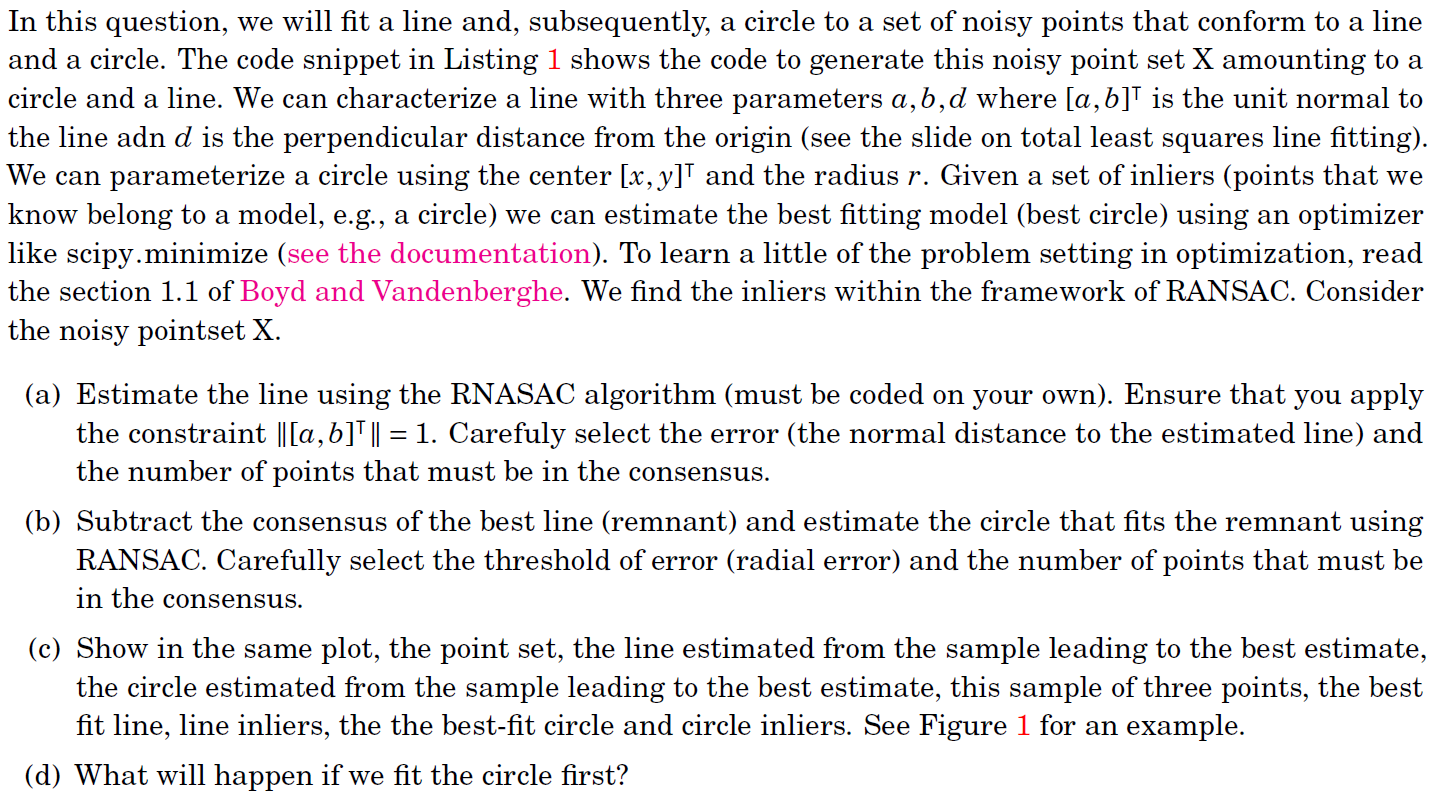

**Imports**

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import math

**Define a function to calculate the line equation using two points**

- ax1+by1=d
- ax2+by2=d
- ................................................................................................................................
- y = mx + c
- m = (y2-y1)/(x2-x1)
- c = y1-mx1
- ................................................................................................................................
- mx - y = -c
- ax + by = d
- a = m , b = -1 , d = -c
- Then normalize the equation by dividing by sqrt(a2+b2)

In [55]:
def find_line_parameters_using_2_points(x1,y1,x2,y2):
        
        m = (y2-y1)/(x2-x1)
        c = y1 - m*x1
        
        a = m
        b = -1
        d = -c
        
        a_normalized = a/math.sqrt(a**2+b**2)
        b_normalized = b/math.sqrt(a**2+b**2)
        d_normalized = d/math.sqrt(a**2+b**2)
        
        return a_normalized,b_normalized,d_normalized

**Define a function to find the line of best fit using RANSAC**

In [56]:
def RANSAC_line_fitting(X, iterations, threshold, min_inliers):

    best_model = None
    best_inliers = []

    for i in range(iterations):
        
        sample_indices = np.random.choice(len(X),2,replace=False)
        x1,y1 = X[sample_indices[0]]
        x2,y2 = X[sample_indices[1]]
        
        a,b,d = find_line_parameters_using_2_points(x1,y1,x2,y2)
        
        magnitude = np.sqrt(a**2 + b**2)
        a = a/magnitude
        b = b/magnitude

        distances = np.abs(a*X[:,0]+b*X[:,1]-d)

        inliers  = np.where(distances<threshold)[0]

        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model   = (a,b,d)
                best_inliers = inliers

    return best_model,best_inliers

**Define a function to find the circle equation using three points**

In [57]:
def find_circle_parameters_using_3_points(x1,y1,x2,y2,x3,y3):

    mx1,my1 = (x1+x2)/2,(y1+y2)/2
    mx2,my2 = (x2+x3)/2,(y2+y3)/2

    if y2-y1 == 0:
        slope1 = 0 
    else:
        slope1 = (x2-x1)/(y2-y1)

    if y3-y2 == 0:
        slope2 = 0 
    else:
        slope2 = (x3-x2)/(y3-y2)

    x_center = (slope1*mx1-slope2*mx2+my2-my1)/(slope1-slope2)
    y_center = -slope1*(x_center-mx1)+my1

    radius = np.sqrt((x1-x_center)**2+(y1-y_center)**2)

    return x_center,y_center,radius

**Define a function to find the circle of best fit using RANSAC**

In [58]:
def RANSAC_circle_fitting(X,iterations,threshold,min_inliers):
    
    best_model   = None
    best_inliers = []
    
    for i in range(iterations):
        sample_indices = np.random.choice(len(X),3,replace=False)
        x1,y1 = X[sample_indices[0]]
        x2,y2 = X[sample_indices[1]]
        x3,y3 = X[sample_indices[2]]
        
        x_center,y_center,radius = find_circle_parameters_using_3_points(x1,y1,x2,y2,x3,y3)
        
        errors  = np.abs(np.sqrt((X[:,0]-x_center)**2+(X[:,1]-y_center)**2)-radius)
        
        inliers = np.where(errors<threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model   = (x_center,y_center,radius)
                best_inliers = inliers
                
    return best_model,best_inliers

**Noisy Data Generation & Getting Required Results & Plots**

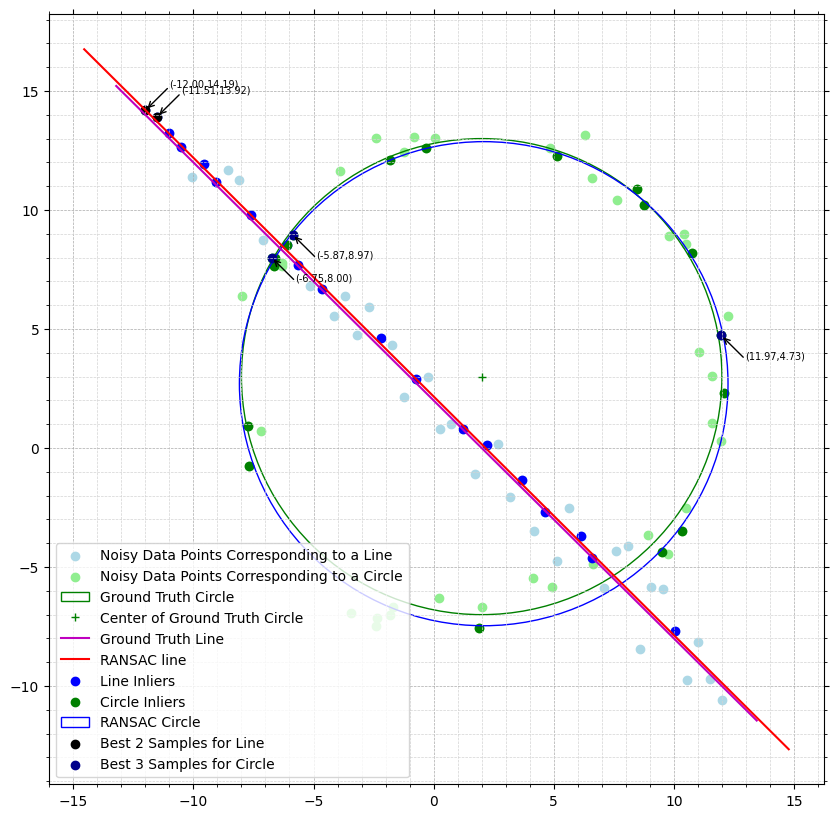

In [59]:
# Generate noisy data points corresponding to a circle and a line
np.random.seed(1)
N = 100
half_n = N//2
r = 10
x0_gt, y0_gt = 2,3  # Center 
s = r/16
t = np.random.uniform(0,2*np.pi,half_n)
n = s * np.random.randn(half_n)
x = x0_gt+(r+n)*np.cos(t)
y = y0_gt+(r+n)*np.sin(t)
X_circ = np.column_stack((x, y))
s = 1.0
m,b = -1,2
x = np.linspace(-12,12,half_n)
y = m*x+b+s*np.random.randn(half_n)
X_line = np.column_stack((x,y))
X = np.vstack((X_circ,X_line))
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(X_line[:,0],X_line[:,1],label='Noisy Data Points Corresponding to a Line',color='lightblue')
ax.scatter(X_circ[:,0],X_circ[:,1],label='Noisy Data Points Corresponding to a Circle',color='lightgreen')
circle_gt = plt.Circle((x0_gt,y0_gt),r,color='g',fill=False,label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt,y0_gt,'+',label='Center of Ground Truth Circle',color='g')
x_min,x_max = ax.get_xlim()
x_ = np.array([x_min,x_max])
y_ = m*x_+b
plt.plot(x_,y_,color='m',label='Ground Truth Line')




# RANSAC parameters for line estimation
iterations  = 100000
threshold   = 0.2
min_inliers = 15

# Estimate the line using RANSAC
best_RANSAC_line,line_inlier_indices_array = RANSAC_line_fitting(X_line,iterations,threshold,min_inliers)

# RANSAC parameters for circle estimation
circle_iterations  = 100000
circle_threshold   = 0.2  
circle_min_inliers = 15

remnant_indices = [i for i in range(len(X)) if i not in line_inlier_indices_array]
remnant_points  = X[remnant_indices]

# Estimate the circle using RANSAC
best_RANSAC_circle, circle_inlier_indices_array = RANSAC_circle_fitting(remnant_points,circle_iterations,circle_threshold,circle_min_inliers)

# Plot the line estimated by RANSAC
x_min,x_max = ax.get_xlim()
x_ = np.array([x_min,x_max])
y_ = (-best_RANSAC_line[0]*x_+best_RANSAC_line[2])/best_RANSAC_line[1]
plt.plot(x_,y_,label='RANSAC line',color='red')

# Plot the inliers of the line
ax.scatter(X_line[line_inlier_indices_array, 0],X_line[line_inlier_indices_array, 1],color='blue',label='Line Inliers')

# Find the best 2 samples for the line (using line_inlier_indices_array)
best_line_sample_indices = line_inlier_indices_array[:2]
best_line_samples = X_line[best_line_sample_indices]

ax.scatter(remnant_points[circle_inlier_indices_array,0],remnant_points[circle_inlier_indices_array,1],color='g',label='Circle Inliers')

# Plot the circle estimated by RANSAC
x_center,y_center,radius = best_RANSAC_circle
circle_estimated = plt.Circle((x_center,y_center),radius,color='blue',fill=False,label='RANSAC Circle')
ax.add_patch(circle_estimated)

# Find the best 3 samples for the circle (using circle_inlier_indices_array)
best_circle_sample_indices = circle_inlier_indices_array[:3]
best_circle_samples = remnant_points[best_circle_sample_indices]

# Plot the best 2 samples for the line and the best 3 samples for the circle
ax.scatter(best_line_samples[:,0], best_line_samples[:,1],color='black',marker='o',label='Best 2 Samples for Line')
ax.scatter(best_circle_samples[:,0], best_circle_samples[:,1],color='darkblue',marker='o',label='Best 3 Samples for Circle')

# Annotations
def annotate_sample(ax,start,end,label):
        ax.annotate("",xy=start,xytext=end,arrowprops=dict(arrowstyle="->",color='black'))
        ax.text(end[0],end[1],label,fontsize=7,ha='left')
for i, sample in enumerate(best_line_samples):
        label = f'({sample[0]:.2f},{sample[1]:.2f})'
        annotate_sample(ax,(sample[0],sample[1]),(sample[0]+1,sample[1]+1),label)
for i, sample in enumerate(best_circle_samples):
        label = f'({sample[0]:.2f},{sample[1]:.2f})'
        annotate_sample(ax,(sample[0],sample[1]),(sample[0]+1,sample[1]-1),label)

# Plot settings
ax.tick_params(which='both', top=True, bottom=True, left=True, right=True)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='--', linewidth=0.5, color='lightgray')
ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='darkgray')
plt.legend()
plt.show()

# Save the figure
fig.savefig('../Outputs/RANSAC.png',dpi=300)

## Question 3

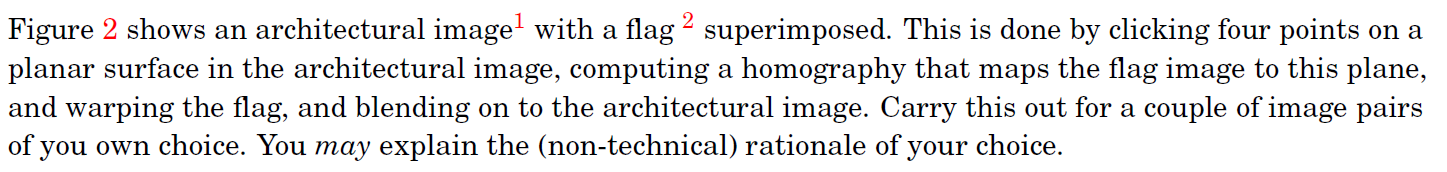

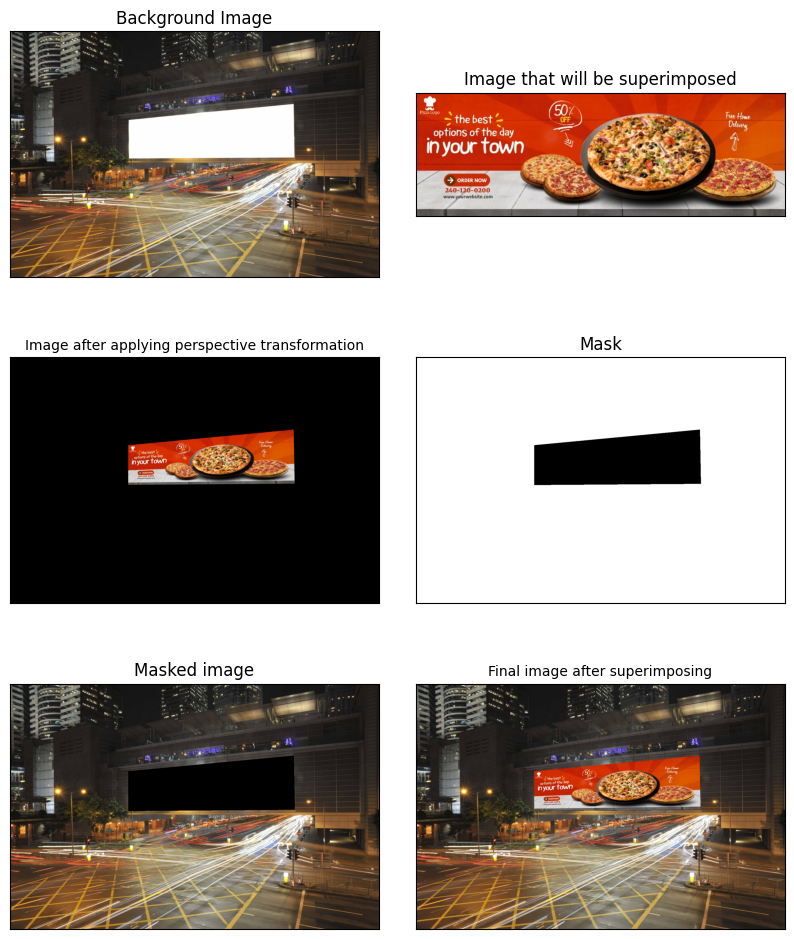

In [60]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


def selecting_points(event,x,y,flags,param):
        # This function will be used as a callback for mouse events. 
        # When the left mouse button is clicked (EVENT_LBUTTONUP), it appends the coordinate (x,y) to the positions list and increments the count variable. 
        # It also draws a small circle on the background_image at the clicked point.
        global positions,count
        if event == cv.EVENT_LBUTTONUP:
                cv.circle(background_image,(x,y),5,(255,100,0),-1)
                positions.append([x,y])
                count = count + 1


# background_image     = cv.imread('../Data/merton_college.jpg')  # Image on which we will be superimposing another image
# image_to_superimpose = cv.imread('../Data/UK_flag.png')         # Image that will be superimposed on the background image
# background_image     = cv.imread('../Data/Laptop_blank_screen.jpeg') 
# image_to_superimpose = cv.imread('../Data/Wallpaper.jpg')      
background_image     = cv.imread('../Data/City_banner.jpg') 
image_to_superimpose = cv.imread('../Data/Pizza_advert.jpg')

positions = []  # List to store the coordinates of the points where the second image has to be placed
count = 0       # Variable to keep track of the number of points selected

cv.namedWindow('Select Points') # Window to display the background image

cv.setMouseCallback('Select Points',selecting_points)
# Sets the mouse callback function to selecting_points. 
# When the user interacts with this window using the mouse, the selecting_points function is called.

while(True):
        cv.imshow('Select Points',background_image) # Displays the background image in the window named 'Select Points'
        k = cv.waitKey(20) 
        if k == 27: # Pressing the escape key will break the loop (ASCII value of escape key is 27)
                break
cv.destroyAllWindows() 

# Read the background image again since it was modified in the previous steps and now it has circles where we clicked
# background_image = cv.imread('../Data/merton_college.jpg') 
# background_image = cv.imread('../Data/Laptop_blank_screen.jpeg')
background_image = cv.imread('../Data/City_banner.jpg')

# Extract the height and width of the background image
height_background,width_background = background_image.shape[:2]

# Extract the height and width of the image that will be superimposed
height_superimposing_image,width_superimposing_image = image_to_superimpose.shape[:2]

# Define two sets of points (pts1 and pts2) that will be used to calculate a perspective transformation
# pts1 are the coordinates of the corners of image_to_superimpose
# pts2 are the user-selected points on the background_image
pts1 = np.float32([[0,0],[width_superimposing_image,0],[0,height_superimposing_image],[width_superimposing_image,height_superimposing_image]])
pts2 = np.float32(positions[:4])

# Find the perspective transformation matrix (h) that aligns image_to_superimpose with the user-selected points on the background_image.
h,mask = cv.findHomography(pts1,pts2,cv.RANSAC,5.0)

height_background,width_background,channels = background_image.shape

# Apply the calculated perspective transformation to image_to_superimpose, creating a new image that matches the perspective of background_image
perspective_transformed_superimposing_image = cv.warpPerspective(image_to_superimpose,h,(width_background,height_background))

# Create a mask with the same shape as the background image
background_mask = np.zeros(background_image.shape[:2], dtype=np.uint8)

# Define the region of interest using the selected positions
positions = [positions[0],positions[2],positions[3],positions[1]]

# Fill the ROI with white color (255,255,255) using cv.fillPoly
cv.fillPoly(background_mask,[np.array(positions)],(255,255,255))

# Invert the mask 
background_mask = cv.bitwise_not(background_mask) 

# Apply the mask to the background image
masked_image = cv.bitwise_and(background_image,background_image,mask=background_mask)

# Use this line to superimpose the image with some transparency
# final = cv.addWeighted(background_image,1,perspective_transformed_superimposing_image,0.8,0)

# Use this line to superimpose the image without any transparency
final = cv.bitwise_or(perspective_transformed_superimposing_image,masked_image)

# Save the final image
# cv.imwrite('../Outputs/UK_flag_on_merton_college_FINAL_IMAGE_ONLY.jpg',final)
# cv.imwrite('../Outputs/Wallpaper_on_laptop_FINAL_IMAGE_ONLY.jpg',final)
cv.imwrite('../Outputs/Pizza_advert_on_city_banner_FINAL_IMAGE_ONLY.jpg',final)

# Display and save the plots
plt.figure(figsize=(10,12))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.subplot(3,2,1)
plt.imshow(cv.cvtColor(background_image,cv.COLOR_BGR2RGB))
plt.title('Background Image',fontsize=12)
plt.xticks([]), plt.yticks([])
plt.subplot(3,2,2)
plt.imshow(cv.cvtColor(image_to_superimpose,cv.COLOR_BGR2RGB))
plt.title('Image that will be superimposed',fontsize=12)
plt.xticks([]), plt.yticks([])
plt.subplot(3,2,3)
plt.imshow(cv.cvtColor(perspective_transformed_superimposing_image,cv.COLOR_BGR2RGB))
plt.title('Image after applying perspective transformation',fontsize=10)
plt.xticks([]), plt.yticks([])
plt.subplot(3,2,4)
plt.imshow(cv.cvtColor(background_mask,cv.COLOR_BGR2RGB))
plt.title('Mask',fontsize=12)
plt.xticks([]), plt.yticks([])
plt.subplot(3,2,5)
plt.imshow(cv.cvtColor(masked_image,cv.COLOR_BGR2RGB))
plt.title('Masked image',fontsize=12)
plt.xticks([]), plt.yticks([])
plt.subplot(3,2,6)
plt.imshow(cv.cvtColor(final,cv.COLOR_BGR2RGB))
plt.title('Final image after superimposing',fontsize=10)
plt.xticks([]), plt.yticks([])
# plt.savefig('../Outputs/UK_flag_on_merton_college_ALL_SUBPLOTS.png')
# plt.savefig('../Outputs/Wallpaper_on_Laptop_ALL_SUBPLOTS.png')
plt.savefig('../Outputs/Pizza_advert_on_city_banner_ALL_SUBPLOTS.png')
plt.show()

References: https://medium.com/acmvit/how-to-project-an-image-in-perspective-view-of-a-background-image-opencv-python-d101bdf966bc

## Question 4

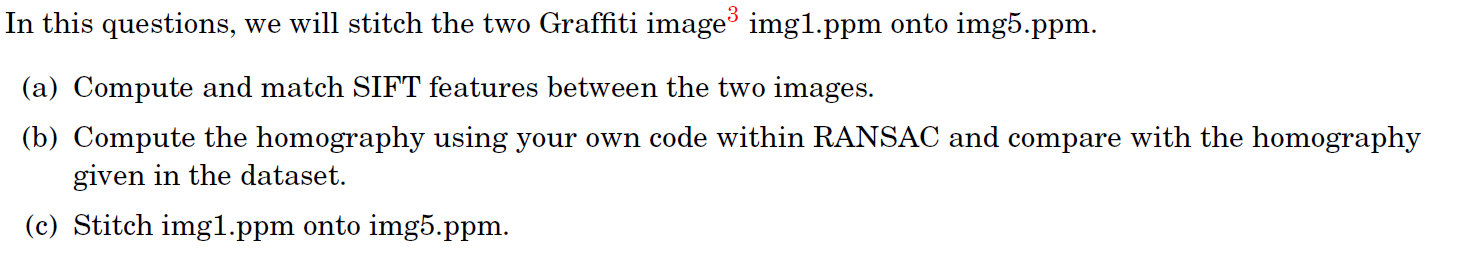

In [61]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

**Functions Definitions**

In [62]:
def Find_Features(image):
    
    sift = cv.SIFT_create()
    keypoint, descriptor = sift.detectAndCompute(image, None)
    return keypoint, descriptor

In [63]:
def Find_Matches_By_Brute_Force(des1, des5):
    
    brute_force_matcher = cv.BFMatcher()
    matches = brute_force_matcher.knnMatch(des1, des5, k=2)
    return matches

In [64]:
def Process_Image(image_path):
    
    image = cv.imread(image_path)
    image_grayscale = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    sift = cv.SIFT_create()
    keypoint, descriptor = sift.detectAndCompute(image_grayscale, None)
    return image, keypoint, descriptor

In [65]:
def Calculate_Homography_Matrix(sample):
    
    M = []
    
    for i in range(len(sample)):
        x1, y1, x2, y2 = sample[i, 0], sample[i, 1], sample[i, 2], sample[i, 3]
        M.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        M.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])
        
    M = np.matrix(M)
    U, S, V = np.linalg.svd(M)
    H = np.reshape(V[-1], (3, 3))
    H = (1/H.item(8))*H
    return H

In [66]:
def Calculate_Geometric_Distance(H, correspondence):
    
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(H, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

In [67]:
def Final_Homography_Matrix_Using_RANSAC(corres,threshold):
    
    max_inliers = []
    homography = []
    
    for i in range(100):
        corr1 = corres[np.random.randint(0, len(corres))]
        corr2 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((corr1, corr2))
        corr3 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((sample, corr3))
        corr4 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((sample, corr4))
        h = Calculate_Homography_Matrix(sample)
        inliers = np.zeros((1,4))
        
        for j in range(len(corres)):
            distance = Calculate_Geometric_Distance(h, corres[j])
            if distance < 5:
                inliers = np.vstack((inliers,corres[j]))

        inliers = np.delete(inliers,0,0)

        if len(inliers) > threshold:
            max_inliers = inliers
            homography = Calculate_Homography_Matrix(max_inliers)

    return homography,max_inliers

**Displaying matches between img1 and img5**

((< cv2.DMatch 0000027154877FB0>, < cv2.DMatch 0000027155D88990>), (< cv2.DMatch 0000027159FBEE30>, < cv2.DMatch 0000027154791930>), (< cv2.DMatch 00000271547918F0>, < cv2.DMatch 0000027154793C50>), (< cv2.DMatch 00000271547933B0>, < cv2.DMatch 0000027154793090>), (< cv2.DMatch 0000027154793D70>, < cv2.DMatch 0000027154793AF0>))


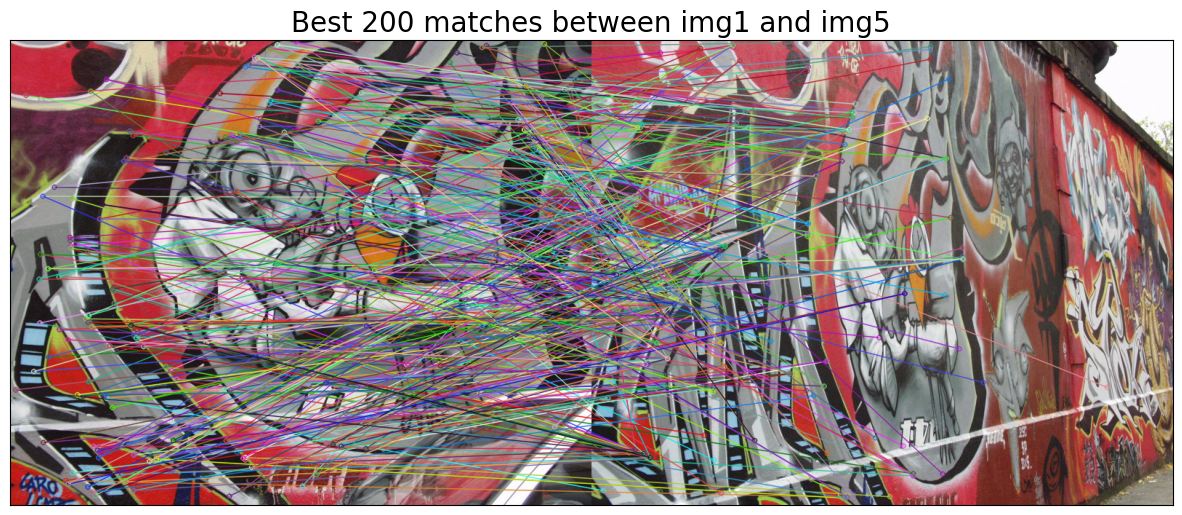

In [68]:
img1 = cv.imread('../Data/graf/img1.ppm')
img5 = cv.imread('../Data/graf/img5.ppm')

img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create()
brute_force_matcher = cv.BFMatcher()

key1, des1 = sift.detectAndCompute(img1_gray, None)
key5, des5 = sift.detectAndCompute(img5_gray, None)

matches = brute_force_matcher.knnMatch(des1, des5, k=2)
print(matches[:5])
matches = sorted(matches, key=lambda x:x[0].distance)

out_img = cv.drawMatchesKnn(img1, key1, img5, key5, matches[:200], img5, flags=2) 
fig, ax = plt.subplots(figsize=(15, 8))
ax.imshow(out_img)
ax.set_xticks([])
ax.set_yticks([])
plt.title('Best 200 matches between img1 and img5', fontsize=20)
plt.show()

- We can see that the matches between img1 and img5 are not very good. If we calculate the homography matrix using these matches, we will get a bad result. 

- So instead of using only img1 and img5, I will use all the images and calculate the homography matrix using the matches between img1 and img2, img2 and img3, img3 and img4, and img4 and img5. Then I will combine all the homography matrices to get the final homography matrix. 

**Displaying matches between all images**

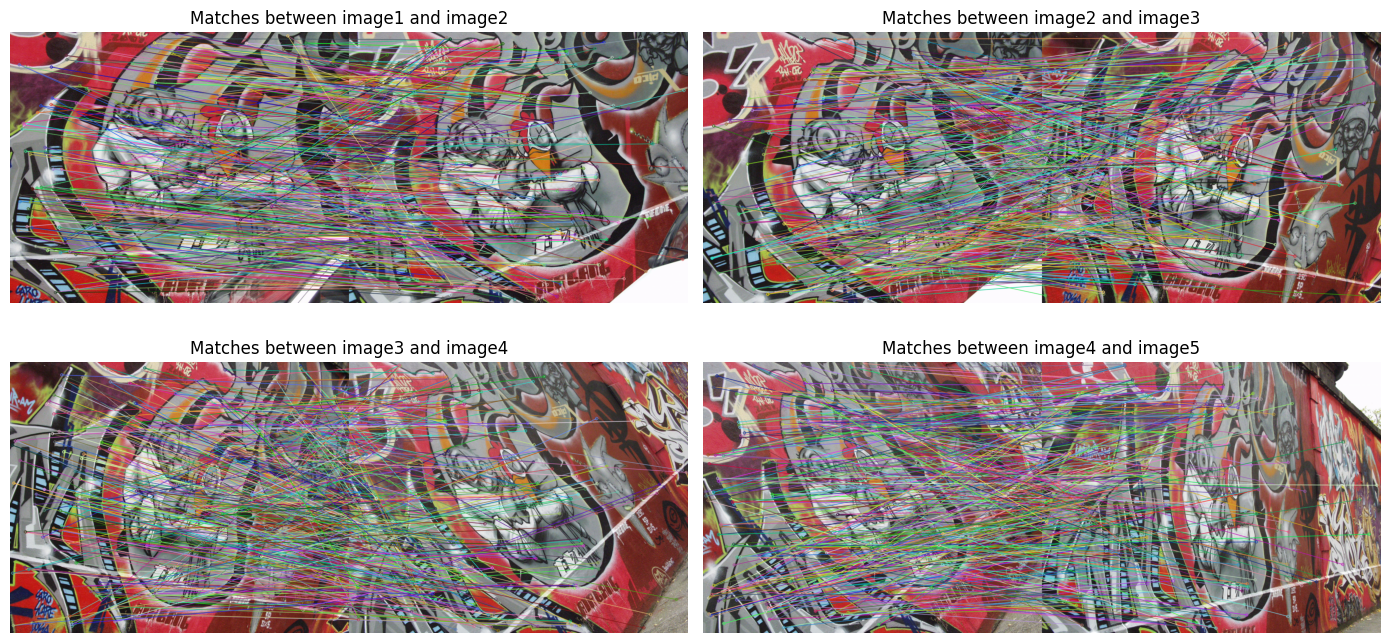

In [69]:
image_paths = ['../Data/graf/img1.ppm', '../Data/graf/img2.ppm', '../Data/graf/img3.ppm', '../Data/graf/img4.ppm', '../Data/graf/img5.ppm']

fig, axes = plt.subplots(2, 2, figsize=(14, 7))

for i in range(4):
    img1, key1, des1 = Process_Image(image_paths[i])
    img2, key2, des2 = Process_Image(image_paths[i+1])
    brute_force_matcher = cv.BFMatcher()
    matches = brute_force_matcher.knnMatch(des1, des2, k=2)
    matches = sorted(matches, key=lambda x: x[0].distance)
    out_img = cv.drawMatchesKnn(img1, key1, img2, key2, matches[:200], img2, flags=2)
    row = i // 2
    col = i % 2
    axes[row, col].imshow(out_img)
    axes[row, col].set_title(f'Matches between image{i+1} and image{i+2}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

**Calculating the homography matrix using the defined functions**

In [70]:
image_array = []

for i in range(1,6):
    image = cv.imread('../Data/graf/img'+str(i)+'.ppm')
    image_array.append(image)

homographs = []
threshold = 100

for i in range(4):
    correspondence = []
    key1, des1 = Find_Features(image_array[i])
    key5, des5 = Find_Features(image_array[i+1])
    keypoints = [key1, key5]
    matches = Find_Matches_By_Brute_Force(des1, des5)
    for match in matches:
        (x1, y1) = keypoints[0][match[0].queryIdx].pt
        (x2, y2) = keypoints[1][match[0].trainIdx].pt
        correspondence.append([x1, y1, x2, y2])
    corres = np.matrix(correspondence)
    H,inliers =Final_Homography_Matrix_Using_RANSAC(corres,threshold)
    homographs.append(H)

final_homograph = homographs[3]@homographs[2]@homographs[1]@homographs[0]
final_homograph = (1/final_homograph.item(8))*final_homograph
print('Calculated Homography\n',final_homograph)
print('Number of inliers',len(inliers))
print()
print('Original Homography\n',open('../Data/graf/H1to5p.txt').read())

Calculated Homography
 [[ 7.50767642e-01  1.44871582e-01  1.89851849e+02]
 [ 3.06867140e-01  1.32819838e+00 -7.02388117e+01]
 [ 6.90913005e-04  7.49002820e-05  1.00000000e+00]]
Number of inliers 255

Original Homography
    6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00



We can see that the calculated homography matrix is very similar to the ground truth homography matrix.

**Stiching images using the calculated homography matrix**

(-0.5, 799.5, 639.5, -0.5)

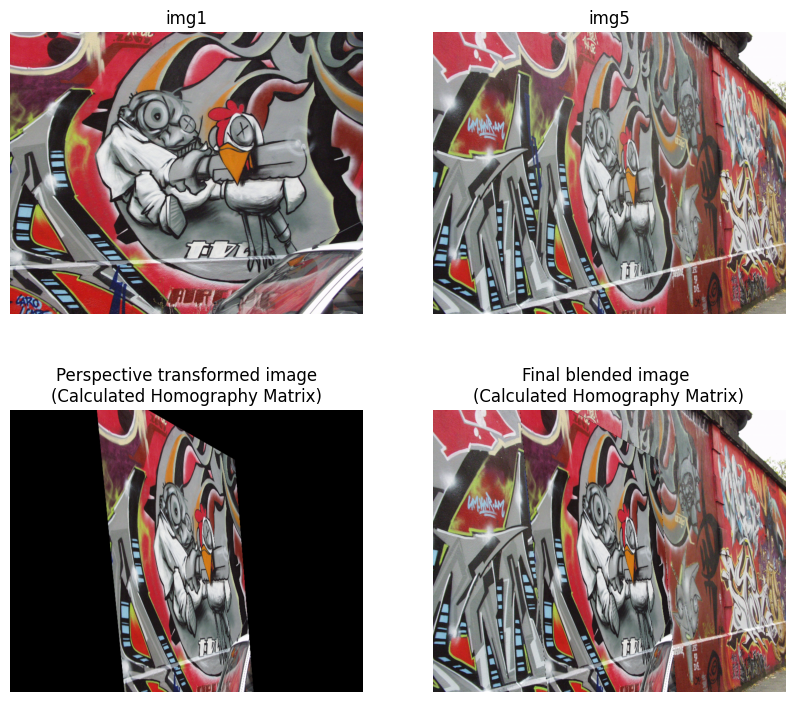

In [71]:
calculated_H = final_homograph

img1 = cv.imread('../Data/graf/img1.ppm')
img5 = cv.imread('../Data/graf/img5.ppm')
fig = plt.figure(figsize=(10, 9))
plt.subplot(2,2,1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('img1')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title('img5')
plt.axis('off')

image_perspective = cv.warpPerspective(img1, calculated_H, (img5.shape[1], img5.shape[0]))
plt.subplot(2,2,3)
plt.imshow(cv.cvtColor(image_perspective, cv.COLOR_BGR2RGB))
plt.title('Perspective transformed image\n(Calculated Homography Matrix)') 
plt.axis('off')

threshold, mask = cv.threshold(cv.cvtColor(image_perspective, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
img5_bg = cv.bitwise_and(img5, img5, mask=mask_inv)
dst = cv.addWeighted(img5_bg, 1, image_perspective, 1, 0)

plt.subplot(2,2,4)
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB)) 
plt.title('Final blended image \n(Calculated Homography Matrix)')
plt.axis('off') 

**Stiching images using the homography matrix given in the dataset**

(640, 800, 3)
(640, 800, 3)


(-0.5, 799.5, 639.5, -0.5)

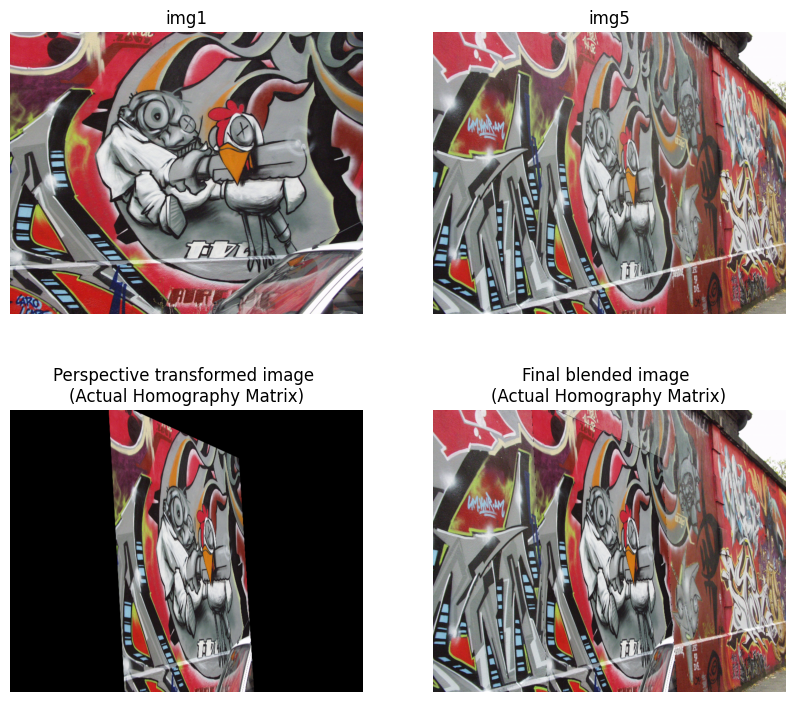

In [72]:
img1 = cv.imread('../Data/graf/img1.ppm')
img5 = cv.imread('../Data/graf/img5.ppm')

fig = plt.figure(figsize=(10, 9))
plt.subplot(2,2,1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('img1')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title('img5')
plt.axis('off')
print(img1.shape)
print(img5.shape)

h_text = open('../Data/graf/H1to5p.txt','r')

original_H = []
for line in h_text:
    line = line.strip()
    line = line.split()
    line = [float(i) for i in line]
    original_H.append(line)
original_H = np.matrix(original_H)

image_perspective = cv.warpPerspective(img1, original_H, (img5.shape[1], img5.shape[0]))
plt.subplot(2,2,3)
plt.imshow(cv.cvtColor(image_perspective, cv.COLOR_BGR2RGB))
plt.title('Perspective transformed image \n(Actual Homography Matrix)')
plt.axis('off')

threshold, mask = cv.threshold(cv.cvtColor(image_perspective, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
img5_bg = cv.bitwise_and(img5, img5, mask=mask_inv)
dst = cv.addWeighted(img5_bg, 1, image_perspective, 1, 0)
output_image = cv.cvtColor(dst, cv.COLOR_BGR2RGB)
plt.subplot(2,2,4)
plt.imshow(output_image) 
plt.title('Final blended image \n(Actual Homography Matrix)')
plt.axis('off')

References: https://github.com/hughesj919/HomographyEstimation/tree/master

***End of the Assignment***